In [1]:
# import public packages
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle
import scipy
import mne
import sys

from mne.time_frequency import tfr_morlet
from mne.baseline import rescale
from scipy.signal import spectrogram, hann, butter, filtfilt, hilbert
from scipy import signal, interpolate, stats
from scipy.interpolate import make_interp_spline, BSpline
from io import open
from importlib import reload

# import own functions
from utils import find_folders
import dat_preproc
import fix_annot_onsets
import mat2fif
import baseline_correction
import normalization

### Add Directories/ Load Files

In [2]:
reload(find_folders)
onedrive = find_folders.get_onedrive_path()
project_path = find_folders.get_onedrive_path("entrainment")
print(project_path)

C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT


In [6]:
fname = 'Derivative_sub005_3MFU_new_ses-2020090909102596_run-BrainSense20200909094100.mat'

raw = mne.io.read_raw_fieldtrip(
    os.path.join(
        project_path,
        'data',
        'raw_data',
        'test',
        fname
    ),
    info = None
)

subID = 'Sub005'

Creating RawArray with float64 data, n_channels=6, n_times=174625
    Range : 0 ... 174624 =      0.000 ...   698.496 secs
Ready.


c:\Users\mathiopv\Anaconda3\lib\site-packages\pymatreader\utils.py:230: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
C:\Users\mathiopv\AppData\Local\Temp\ipykernel_2308\3224474518.py:3: RuntimeWarning: Importing FieldTrip data without an info dict from the original file. Channel locations, orientations and types will be incorrect. The imported data cannot be used for source analysis, channel interpolation etc.
  raw = mne.io.read_raw_fieldtrip(
C:\Users\mathiopv\AppData\Local\Temp\ipykernel_2308\3224474518.py:3: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  raw = mne.io.read_raw_fieldtrip(
C:\Users\mathiopv\AppData\Local\Temp\ipykernel_2308\3224474518.py:3: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_

In [59]:
reload(dat_preproc)
%matplotlib qt
matplotlib.rc('font', size=10)
x = raw.get_data(reject_by_annotation = 'omit',picks=[0,1])
raw = raw
win_samp = 250
noverlap = 0.5
window = hann(win_samp, sym=False)
f, t, Sxx = dat_preproc.fft_rawviz(raw, x, win_samp, noverlap)

In [10]:
fft_name = str(subID)+'_FFT'
print(fft_name)

Sub005_FFT


In [13]:
#Saving the figures & files
fft_fig = os.path.join(project_path, 'figures','FFts','test/')
fft_file = os.path.join(project_path, 'data','FFTs','test/')

plt.savefig(str(fft_fig)+str(fft_name),dpi = 300)

np.save(str(fft_file)+str(fft_name)+'.npy',Sxx)

In [ ]:
#Saving the raw data as a fif file
raw2 = raw.copy()
Draw = raw2.get_data()
info = raw.info
new_raw = mne.io.RawArray(Draw, info)

fif_name = os.path.join(project_path, 'data','Fifs','test/',str(subID)+'_FIF.fif')
new_raw.save(fif_name)


In [23]:
''''
test_raw = mne.io.read_raw_fif(os.path.join(
    project_path,
        'data',
        'Fifs',
        'test',
        'Sub005_FIF.fif'
    )
)
'''

Opening raw data file C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\test\Sub005_FIF.fif...
    Reading extended channel information
    Range : 0 ... 174624 =      0.000 ...   698.496 secs
Ready.


C:\Users\mathiopv\AppData\Local\Temp\ipykernel_2308\3460004522.py:1: RuntimeWarning: This filename (C:Users\mathiopv\OneDrive - Charité - Universitätsmedizin Berlin\ENTRAINMENT_PROJECT\data\Fifs\test\Sub005_FIF.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  test_raw = mne.io.read_raw_fif(os.path.join(


In [135]:
#Zscore Normalization of raw data & plot of new figure
reload(baseline_correction)
data = Sxx[1,:,]
t = t
baseline = (None, None)
raw = new_raw
stim_ch = 1
bs_data = baseline_correction.baseline_corr(data, t, baseline, raw = new_raw, stim_ch = 5)

Applying baseline correction (mode: zscore)


In [136]:
fft_fig = os.path.join(project_path, 'figures','FFts','test/')
fft_file = os.path.join(project_path, 'data','FFTs','test/')

plt.savefig(str(fft_fig)+str(fft_name)+'_zscored',dpi = 300)
np.save(str(fft_file)+str(fft_name)+'_zscored'+'.npy',bs_data)

In [119]:
d = {'onset': [1, 440, 642],
    'duration': [30, 30, 10],
    'description': ['StimOff','StimOn','Rebound']
}

epoch_df = pd.DataFrame(data = d)
print(epoch_df)

   onset  duration description
0      1        30     StimOff
1    440        30      StimOn
2    642        10     Rebound


In [124]:
## Print Power Spectra with Raw Data
reload(dat_preproc)
filt_dat = raw.get_data()
time_onsets = epoch_df
window = 250
noverlap = 0.5
ylim2 = 0.2

fig = plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
title1 = str(subID)+ '_LSTN'
ps1 = dat_preproc.epoch_ps(filt_dat, time_onsets, window, noverlap, 0, 0.1, title1)

plt.subplot(1,2,2)
title2 = str(subID)+ '_RSTN'
ps2 = dat_preproc.epoch_ps(filt_dat, time_onsets, window, noverlap, 1, 0.5, title2)

plt.show()

In [116]:
## Print Power Spectra with Zscored Data
fig = plt.figure(figsize = (5,5))
ps_m1s0 = np.mean(bs_data[:,epoch_df.onset[0]:epoch_df.onset[0]+ epoch_df.duration[0] ],1)
ps_m1s1 = np.mean(bs_data[:,epoch_df.onset[1]:epoch_df.onset[1]+ epoch_df.duration[1] ],1)
ps_reb = np.mean(bs_data[:,epoch_df.onset[2]:epoch_df.onset[2]+ epoch_df.duration[2] ],1)

plt.plot(np.arange(1,127),ps_m1s0,1)
plt.plot(np.arange(1,127),ps_m1s1,1)
plt.plot(np.arange(1,127),ps_reb,1)

plt.xlim(60,90)
plt.show()

In [121]:
ps_all = np.concatenate((ps1,ps2), axis = 0)
ps_df = pd.DataFrame(np.transpose(ps_all),
    columns = ['StimOff_LSTN','StimOn_LSTN','Rebound_LSTN',
    'StimOff_RSTN','StimOn_RSTN','Rebound_RSTN'],
    )
print(ps_df)

     StimOff_LSTN  StimOn_LSTN  Rebound_LSTN  StimOff_RSTN  StimOn_RSTN  \
0        0.377289     0.597056      0.858927      0.203042     0.117614   
1        1.911971     2.370553      3.930662      0.810503     0.544581   
2        2.513051     1.907679      3.551067      1.067583     0.710760   
3        1.677302     1.264834      2.196010      0.609942     0.459279   
4        1.402737     0.838451      2.721627      0.239860     0.309105   
..            ...          ...           ...           ...          ...   
121      0.004851     0.006122      0.003814      0.000703     2.071120   
122      0.000209     0.000190      0.000202      0.000120     0.004963   
123      0.000210     0.000197      0.000211      0.000158     0.000583   
124      0.000180     0.000161      0.000196      0.000196     0.000320   
125      0.000082     0.000064      0.000095      0.000085     0.000184   

     Rebound_RSTN  
0        0.221126  
1        1.333687  
2        1.574420  
3        0.915520  

In [125]:
#Saving the figures & files
fft_fig = os.path.join(project_path, 'figures','Power_Spectra','test/')
fft_file = os.path.join(project_path, 'data','power_spectra','test/')

plt.savefig(str(fft_fig)+str(fft_name), dpi = 150)

ps_df.to_csv(str(fft_file)+str(fft_name)+ '.csv')

### Average all Power Spectra and Plot them

In [36]:
all_ps = pd.read_csv(os.path.join(
    project_path,
        'data',
        'power_spectra',
        'test',
        'AllPS_GammaIpsi.csv'
))

In [53]:
all_ps_mean = np.mean(all_ps,1)
all_ps_sem = stats.sem(all_ps_mean)

(0.0, 0.1)

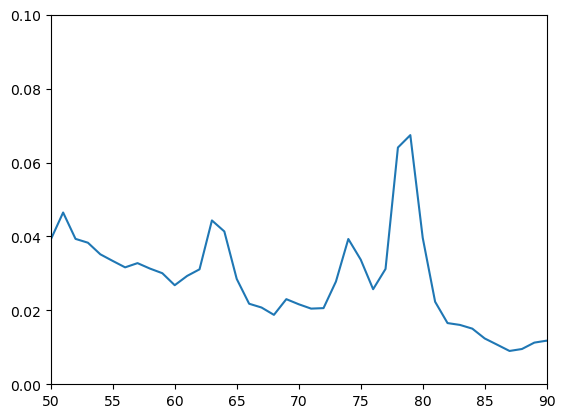

In [70]:
plt.plot(np.arange(1,127), all_ps_mean)
#plt.fill_between(np.arange(1,127), all_ps_mean-all_ps_sem, all_ps_mean+all_ps_sem, alpha = 0.2)
plt.xlim(50, 90)
plt.ylim(0, 0.1)